In [1]:
# making training data from annotations

In [256]:
## Import libraries

# general
import os
import gc
import glob
import math
import numpy as np
import itertools
import slidingwindow as sw

# rasters
import rasterio
from rasterio.mask import mask

# shapes
import fiona
import shapefile
import shapely
from shapely.geometry import shape, Polygon, box, MultiPolygon
from shapely.ops import cascaded_union, unary_union

# for transormations
import pyproj
from shapely.ops import transform
from functools import partial

# working with images
from PIL import Image
from skimage import exposure
from skimage.io import imsave, imread

# visualizations
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [257]:
# load helper functions

def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return int(UTM_EPSG_code)

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list

In [281]:
# set parameters

chunk_size_pix = 400
overlap_frac = 0.2
label = 'tree'

# set bands https://sites.google.com/a/daffodilsw.com/green-city-watch/project-guidelines/data
band_list = [3,6,5] 

# define paths with training data polygons
annotations_file_path = '../../data/data_merged/annotations/*.shp'

# define paths with raster data
rasters_file_path = '../../data/data_merged/tif/*.tif'

# define paths with contrast polygon (area with trees)
contrast_file_path = '../../data/data_merged/*.shp'

# output folder
output_path = '../../data/data_merged/training_data/'

In [263]:
# find all files in folders for specific classes
# find current working directory 
cwd = os.getcwd()

# find files in shapefile folder
annotations_shape_files = glob.glob(annotations_file_path)

# find files in raster folder
raster_files = glob.glob(rasters_file_path)
raster_files, annotations_shape_files
# load raster data
dataset = rasterio.open(raster_files[0])

# load annotations
annotations_valid_shape_list = check_valid_geometries(annotations_shape_files[0])
# convert list to shapely MultiPolgyons
annotations_MultiPoly = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(annotations_shape_files[0])])

number of annotations:  4946


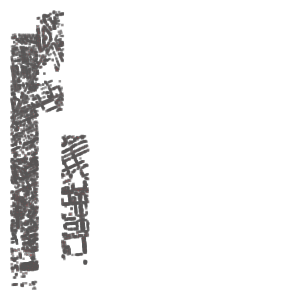

In [264]:
# inspect annotations
print('number of annotations: ', len(annotations_MultiPoly))
annotations_MultiPoly

In [265]:
# crop raster file to annotation extend
x_min_annotations, y_min_annotations, x_max_annotations, y_max_annotations = annotations_MultiPoly.bounds
chunk_bbox_org = box(x_min_annotations, y_min_annotations, x_max_annotations, y_max_annotations)
# crop
out_img, out_transform = mask(dataset, shapes=[chunk_bbox_org], crop=True)

In [266]:
## get raster bbox
# convert bounds to polygon
x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
poly_raster_bounds = Polygon([(x_min_data, y_min_data), 
                              (x_min_data, y_max_data), 
                              (x_max_data, y_max_data), 
                              (x_max_data, y_min_data)])


# get raster metadata

x_pix_size_m = dataset.meta['transform'][0]
y_pix_size_m = dataset.meta['transform'][4]

x_raster_size_pix = dataset.meta['width']
y_raster_size_pix = dataset.meta['height']

In [267]:
# check overlap between annotations and raster
annotations_MultiPoly_union = unary_union(annotations_MultiPoly)
    
total_n = len(annotations_MultiPoly_union)
overlap_n = len(poly_raster_bounds.intersection(annotations_MultiPoly_union))

# check if overlap is complete
if  overlap_n == total_n:
    print('datasets overlap entirely')
else:
    print('Datasets do not completely overlap')
    print('Overlap is:' ,round(overlap_n/total_n,3)*100, '% ', overlap_n, '/', total_n)

datasets overlap entirely


In [268]:
# Generate the set of windows
windows = sw.generate(np.rot90(np.fliplr(dataset.read().T)), sw.DimOrder.HeightWidthChannel, chunk_size_pix, overlap_frac)

In [270]:
## calculate band min max for specific bands base on selected area
# find files in shapefile folder
contrast_shape_files = glob.glob(contrast_file_path)
contrast_valid_shape_list = check_valid_geometries(contrast_shape_files[0])

# convert list to shapely MultiPolgyons
contrast_shape = shape(contrast_valid_shape_list[0]['geometry'])

out_img_chunk, out_transform_chunk = mask(dataset, shapes=[contrast_shape], crop=True)

img_plot_raw = out_img_chunk[band_list,:,:]
img_plot = np.rot90(np.fliplr(img_plot_raw.T))

band_minmax = []

for band in range(3):
    p_1, p_2 = np.percentile(img_plot[:,:,band], (2, 98))

    band_minmax.append([p_1, p_2])
    
band_minmax

[[735.0, 1469.0], [1371.0, 4620.0], [909.0, 2200.0]]

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


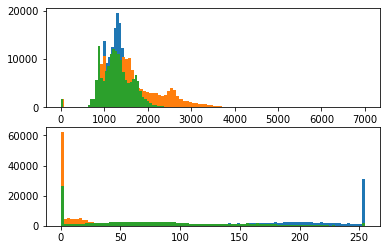

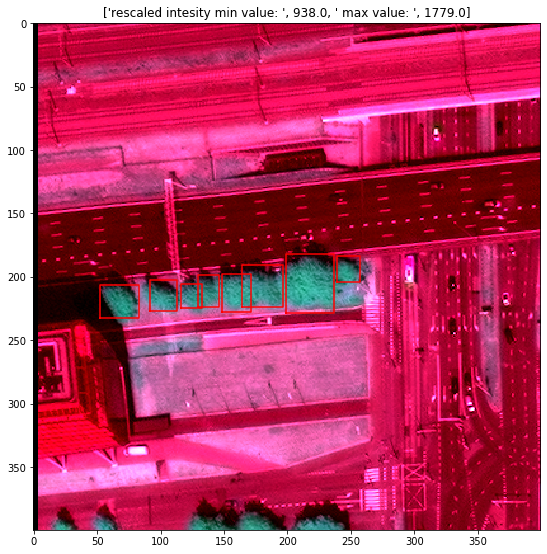

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


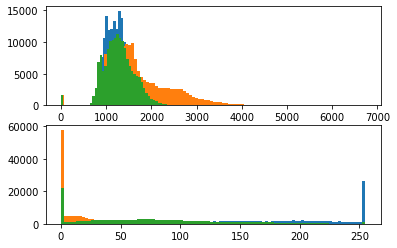

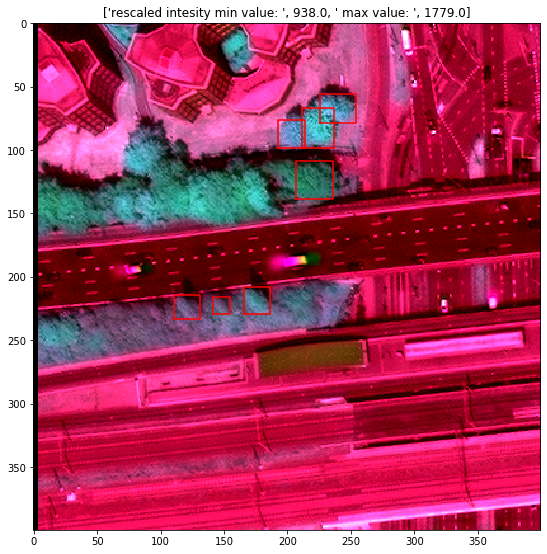

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


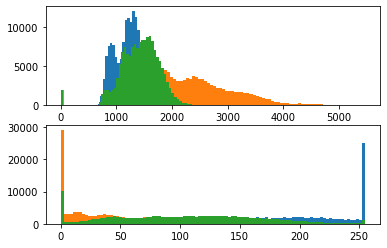

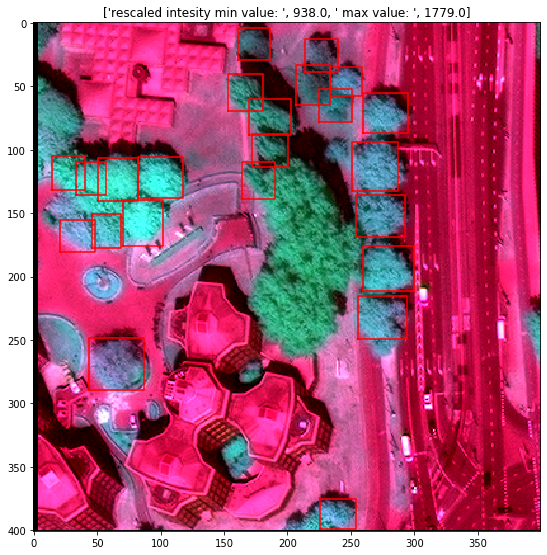

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


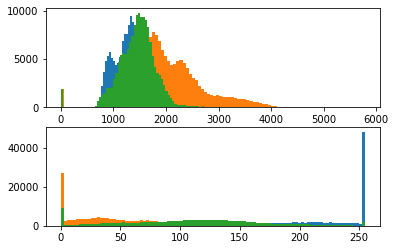

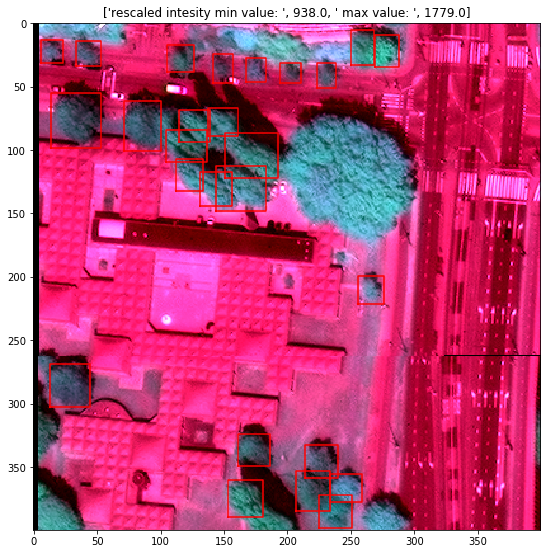

/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/chris/anaconda3/envs/GISpy_1/lib/python3.7/site-packages/ipykernel_launcher.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


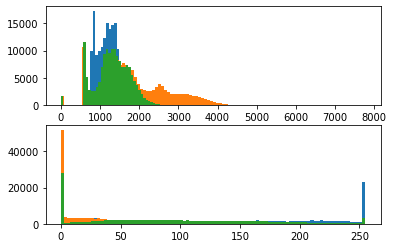

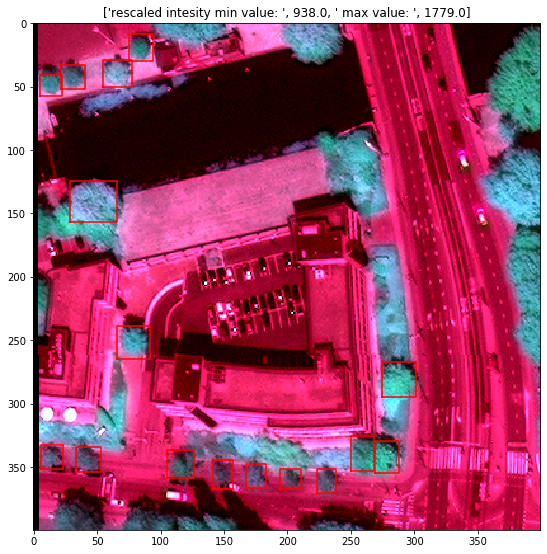

In [292]:
# loop over chunks 
plot_results = True

import cv2

for i in tqdm(range(5)):

        # convert chunk coordinates to bbox
        x_min = (windows[i].x * x_pix_size_m) + x_min_data
        x_max = ((windows[i].x + windows[i].w) * x_pix_size_m) + x_min_data
        y_min = (windows[i].y * abs(y_pix_size_m)) + y_min_data
        y_max = ((windows[i].y + windows[i].h) * abs(y_pix_size_m)) + y_min_data
    
        # read dataset
        dataset = rasterio.open(raster_files[0])
        x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
        
        # clip raster file
        poly_chunk_bounds = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]) 
        out_img_chunk, out_transform_chunk = mask(dataset, shapes=[poly_chunk_bounds], crop=True)
                      
        # loop over tree bboxes
        x_min_chunk = out_transform_chunk[2]
        y_min_chunk = out_transform_chunk[5]
      
        # select only bboxes that are fully within the chunk
        chunk_MultiPoly = MultiPolygon([poly_chunk_bounds.intersection(poly) for poly in annotations_MultiPoly if poly.within(poly_chunk_bounds)])
        
        # only continue if there are boxes
        if len(chunk_MultiPoly) == 0:
            print('no annotations in chunk', i)
            continue
        
        # get band data from raster and transform
        img_plot_raw = out_img_chunk[band_list,:,:]
        img_plot = np.rot90(np.fliplr(img_plot_raw.T))
        img_plot_enhance = np.array(img_plot, copy=True)
    
        ##### tif file #####
        # generate tiff profile 
        profile = dataset.profile
        profile['transform'] = out_transform_chunk
        profile['width'] = windows[i].w
        profile['height'] = windows[i].h
        
        # write tif file
        file_path_tif = '{0}example_{1:03d}.tif'.format(output_path,i)
        file_name_tif = 'example_{0:03d}.tif'.format(i)
        with rasterio.open(file_path_tif, 'w', **profile) as dst:
            dst.write(out_img_chunk)
        
        ##### jpg file #####
        # apply band specific contrast optimization
        for band in range(3):            
            p_1, p_2 = band_minmax[band]
            img_plot_enhance[:,:,band] = exposure.rescale_intensity(img_plot[:,:,band], 
                                                            in_range=(p_1, p_2), 
                                                            out_range = 'uint8')

        # write jpg file
        file_path_jpg = '{0}example_{1:03d}.jpg'.format(output_path,i)
        file_name_jpg = 'example_{0:03d}.jpg'.format(i)
        imsave(file_path_jpg, img_plot_enhance.astype('uint8'))
                        
        ##### annotations files #####
        # get annotation coordinates
        x = abs(np.array([poly.exterior.coords.xy[0] for poly in chunk_MultiPoly]) - x_min_chunk) * 1/out_transform_chunk[0]
        y = abs(np.array([poly.exterior.coords.xy[1] for poly in chunk_MultiPoly]) - y_min_chunk) * 1/out_transform_chunk[0]

        # write annotations to annotation file
        for i in range(len(x)):
            x_min_bbox = np.round(x[0]).astype(int).min()
            x_max_bbox = np.round(x[0]).astype(int).max()
            y_min_bbox = np.round(y[0]).astype(int).min()
            y_max_bbox = np.round(y[0]).astype(int).max()
            
            string_list = [file_name_tif, str(x_min_bbox), str(x_max_bbox), str(y_min_bbox), str(y_max_bbox), label]
            string = ",".join(string_list)
            
            with open('{0}annotations_tif.txt'.format(output_path,i), 'a') as file:
                file.write(string + "\n")
            
            string_list = [file_name_jpg, str(x_min_bbox), str(x_max_bbox), str(y_min_bbox), str(y_max_bbox), label]
            string = ",".join(string_list)
            
            with open('{0}annotations_jpg.txt'.format(output_path,i), 'a') as file:
                file.write(string + "\n")
           
        
        ##### plotting #####        
        if plot_results:
            
            for band in range(3):
                plt.subplot(211, label = 'bands')
                plt.hist(img_plot[:,:,band].flatten(),100)
                plt.subplot(212, label = 'bands')
                plt.hist(img_plot_enhance[:,:,band].flatten(),100)
                
            plt.show()
            
            plt.figure(figsize = (20,20))
            plt.subplot(121)
            plt.title(['rescaled intesity min value: ', p1, ' max value: ', p99])
            plt.imshow(img_plot_enhance.astype('uint8')) 

            for i in range(len(x)):
                plt.plot(x[i],y[i], color = 'red')
                
            plt.show()     
        
        # clear memory
        gc.collect()
        